%md
# Análise de Crédito - Análise Exploratória

# Import

In [1]:
import pandas as pd
import os
import typing
import seaborn as sns
import warnings
import numpy as np
import matplotlib.pyplot as plt; 
from utils import *
from pathlib import Path

In [2]:
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

# Parameters

In [46]:
DATASET = Path("../datasets/dataset.csv")
DESC_DATASET = Path("../datasets/description.csv")
TARGET_VARIABLE = "sent_to_analysis"
SEED = 111111 
REMOVE_COLS = ["id", "city", "state", "informed_purpose","zip_code","pre_approved"] # Colunas para serem removidas da parte de características
LOG_SCALE_COL = ["monthly_income","collateral_value","loan_amount","collateral_debt","monthly_payment","auto_year"]
PAIR_PLOT = ["monthly_income","collateral_value","loan_amount","collateral_debt","monthly_payment","auto_year","age","sent_to_analysis"]

# Definitions

In [4]:
np.seed = SEED 

In [52]:
def plot_histograms(df: pd.DataFrame, variable_list: typing.List[str], bins: int = 20, kde: bool = None, log_scale: bool = False, hue=None):
    plt.figure(figsize=(10, 14))
    for i, column in enumerate(variable_list, 1):
        plt.subplot(4,3,i)
        sns.histplot(df[column], bins=20, kde=kde, color='skyblue', log_scale=log_scale, hue=hue)
        plt.title(f'Histogram of {column}')
        plt.xticks([])  # Esto elimina las etiquetas del eje x
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

In [70]:
def plot_boxplot(df: pd.DataFrame, variable_list: typing.List[str],  hue=None):
    plt.figure(figsize=(10, 14))
    for i, column in enumerate(variable_list, 1):
        plt.subplot(4,3,i)
        sns.countplot(df, x=column, color='skyblue', hue=hue, orient="x")
        plt.title(f'Barplot of {column}')
        plt.xticks([])  # Esto elimina las etiquetas del eje x
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Explore

In [6]:
df = load_dataset(DESC_DATASET)
pd.set_option('max_colwidth', 50)
print(df)

                      id          Chave única de uma solicitação de cliente
0                    age                                  Idade do cliente 
1         monthly_income  Renda mensal informada pelo cliente no momento...
2       collateral_value       Valor do automóvel que será dado em garantia
3            loan_amount      Valor solicitado pelo cliente para empréstimo
4                   city                                  Cidade do cliente
5                  state                                  Estado do cliente
6        collateral_debt  Valor que o automovel do cliente tem de dívida...
7   verified_restriction  Indica se o cliente possui alguma restrição/pe...
8      dishonored_checks       Indica se o cliente possui cheques sem fundo
9          expired_debts        Indica se o cliente possui dívidas vencidas
10         banking_debts       Indica se o cliente possui divídas bancárias
11      commercial_debts      Indica se o cliente possui dividas comerciais
12          

In [7]:
df = load_dataset(DATASET)

In [8]:
df

,id,age,monthly_income,collateral_value,loan_amount,city,state,collateral_debt,verified_restriction,dishonored_checks,...,pre_approved,form_completed,sent_to_analysis,channel,zip_code,landing_page,landing_page_product,gender,utm_term,education_level
0,100001025857,61.0,1300.0,NaN,10000.00,NaN,NaN,NaN,NaN,0,...,0.0,1.0,0.0,NaN,5754XXXX,NaN,NaN,male,NaN,NaN
1,173466,50.0,3500.0,40000.0,23936.00,Muriaé,MG,NaN,1.0,0,...,0.0,0.0,0.0,search,3688XXXX,/emprestimo/garantia-veiculo,AutoRefinancing,NaN,c,NaN
2,173465,31.0,2600.0,18000.0,5000.00,Araxá,MG,10000.0,0.0,0,...,0.0,1.0,0.0,display,3818XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
3,173464,51.0,3600.0,21000.0,10000.00,Jaú,SP,8000.0,1.0,0,...,0.0,0.0,0.0,0,1720XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,NaN,NaN
4,173463,51.0,1500.0,10000.0,8000.00,Veranópolis,RS,0.0,NaN,0,...,0.0,0.0,0.0,display,9533XXXX,/emprestimos/solicitar,PersonalLoan,male,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35016,98335,34.0,850.0,14000.0,5000.00,Carpina,PE,1000.0,0.0,0,...,1.0,0.0,0.0,remarketing,5581XXXX,/emprestimos/solicitar,PersonalLoan,male,c,Da 5ª à 8ª série do ensino fundamental (antigo...
35017,98333,24.0,778.0,26000.0,5320.67,Petrópolis,RJ,NaN,0.0,0,...,1.0,0.0,0.0,search,2565XXXX,/,HomePage,male,c,"Ensino médio incompleto (antigo 2º grau, secun..."
35018,98328,37.0,780.0,10000.0,5334.35,Recife,PE,0.0,NaN,0,...,0.0,0.0,0.0,display,5079XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,"Ensino médio completo (antigo 2º grau, secundá..."
35019,98327,50.0,3000.0,25000.0,20516.72,Santana de Parnaíba,SP,NaN,0.0,0,...,1.0,0.0,0.0,remarketing,6525XXXX,/emprestimos/garantia-veiculo/solicitar,NaN,male,c,4ª série completa do ensino fundamental (antig...


In [9]:
df.shape

(35021, 32)

In [10]:
df[(df["sent_to_analysis"] == 0) & (df["pre_approved"] == 1)].shape

(11730, 32)

In [11]:
df[(df["sent_to_analysis"] == 1) & (df["pre_approved"] == 1)].shape

(3269, 32)

In [12]:
df[(df["sent_to_analysis"] == 1) & (df["pre_approved"] == 0)].shape

(0, 32)

In [13]:
df = df[df["pre_approved"] == 1]

In [14]:
df.shape

(14999, 32)

----------------------------------------------------------------------------

In [15]:
# Nulls
percent_missing = df.isnull().sum() * 100 / len(df)
missing_value_df = pd.DataFrame({'percent_missing': percent_missing})

In [16]:
missing_value_df

,percent_missing
id,0.000000
age,0.000000
monthly_income,0.000000
collateral_value,0.086672
loan_amount,0.000000
city,0.053337
state,0.000000
collateral_debt,35.382359
verified_restriction,0.426695
dishonored_checks,0.000000


-----------------------------------------------------------------------------------------------------

In [17]:
# Summary

In [18]:
df.describe().apply(lambda x: x.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
id,14999.00000,142736.80612,19975.50925,98327.00000,128630.00000,145687.00000,159355.50000,173460.00000
age,14999.00000,38.36409,11.60066,18.00000,30.00000,36.00000,46.00000,115.00000
monthly_income,14999.00000,11004.52681,153879.50369,0.00000,2500.00000,4000.00000,6000.00000,11000000.00000
collateral_value,14986.00000,49108.99766,987560.32996,0.00000,17000.00000,23000.00000,33486.00000,99999999.00000
loan_amount,14999.00000,14669.10607,13961.08634,2500.00000,6000.00000,10500.00000,18900.00000,719000.00000
collateral_debt,9692.00000,4375.59203,103353.09892,0.00000,0.00000,0.00000,2000.00000,10100000.00000
verified_restriction,14935.00000,0.14155,0.34860,0.00000,0.00000,0.00000,0.00000,1.00000
dishonored_checks,14999.00000,0.01900,0.13653,0.00000,0.00000,0.00000,0.00000,1.00000
expired_debts,14999.00000,0.00267,0.05157,0.00000,0.00000,0.00000,0.00000,1.00000
banking_debts,14999.00000,0.06120,0.23971,0.00000,0.00000,0.00000,0.00000,1.00000


-----------------------------------------------------------------------------------------------------------------

# Limpando Erros e Removendo Algumas Linhas Indesejáveis

In [19]:
df = df[(df["collateral_debt"] < 100000) | df["collateral_debt"].isna()]
df.shape

(14995, 32)

In [20]:
df = df[(df["collateral_value"] < 1000000) | df["collateral_value"].isna()]
df.shape

(14980, 32)

In [21]:
df = df[(df["monthly_income"] < 1000000) | df["monthly_income"].isna()]
df.shape

(14951, 32)

In [22]:
df = df[(df["monthly_payment"] < 10000) | df["monthly_payment"].isna()]
df.shape

(14947, 32)

In [101]:
df.to_csv("../datasets/dataset_cleaned.csv",index=None)

---------------------------------------------------------------------------

In [23]:
# Distribution

In [24]:
num_cols, cat_cols = get_num_cat_cols(df, TARGET_VARIABLE, REMOVE_COLS)

Categóricas


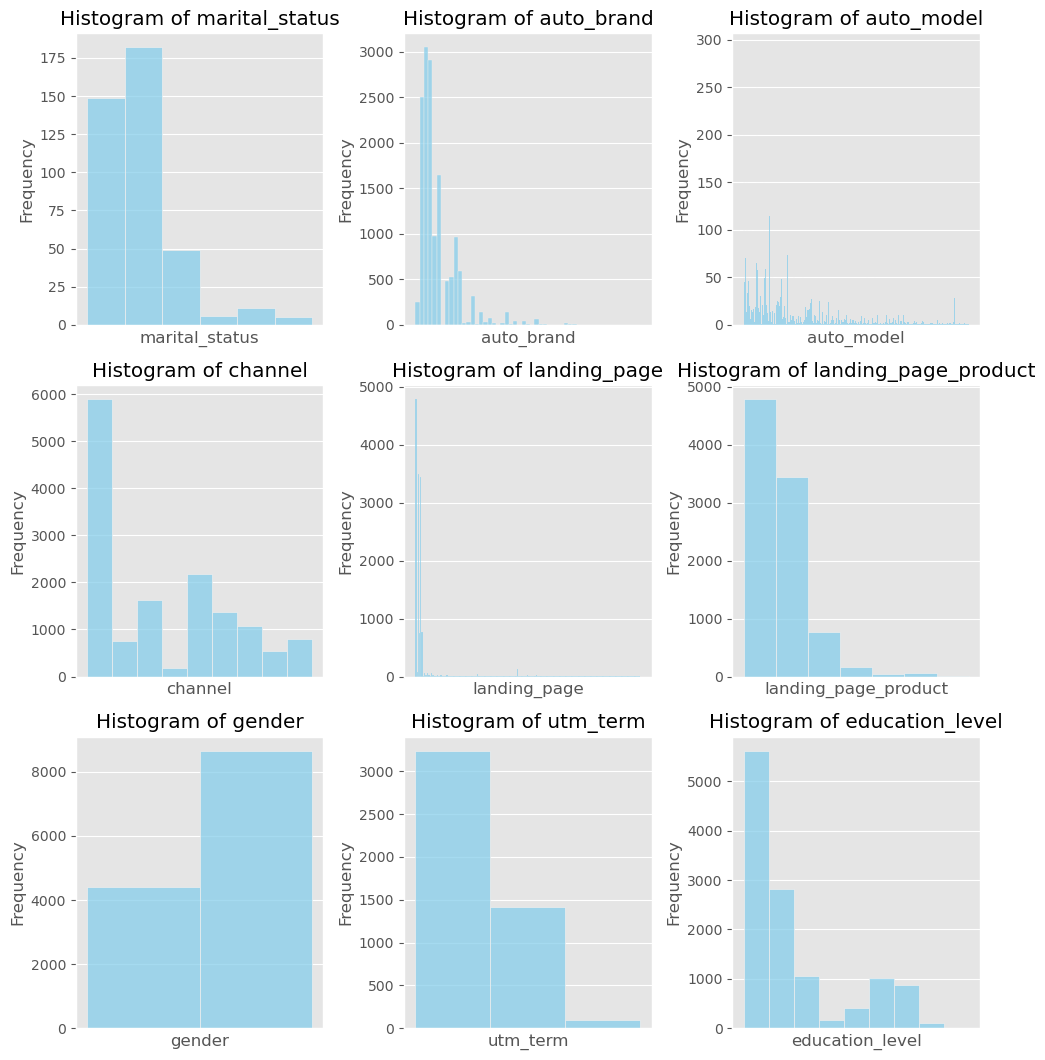

In [25]:
print('Categóricas')
plot_histograms(df, cat_cols)

Numéricas


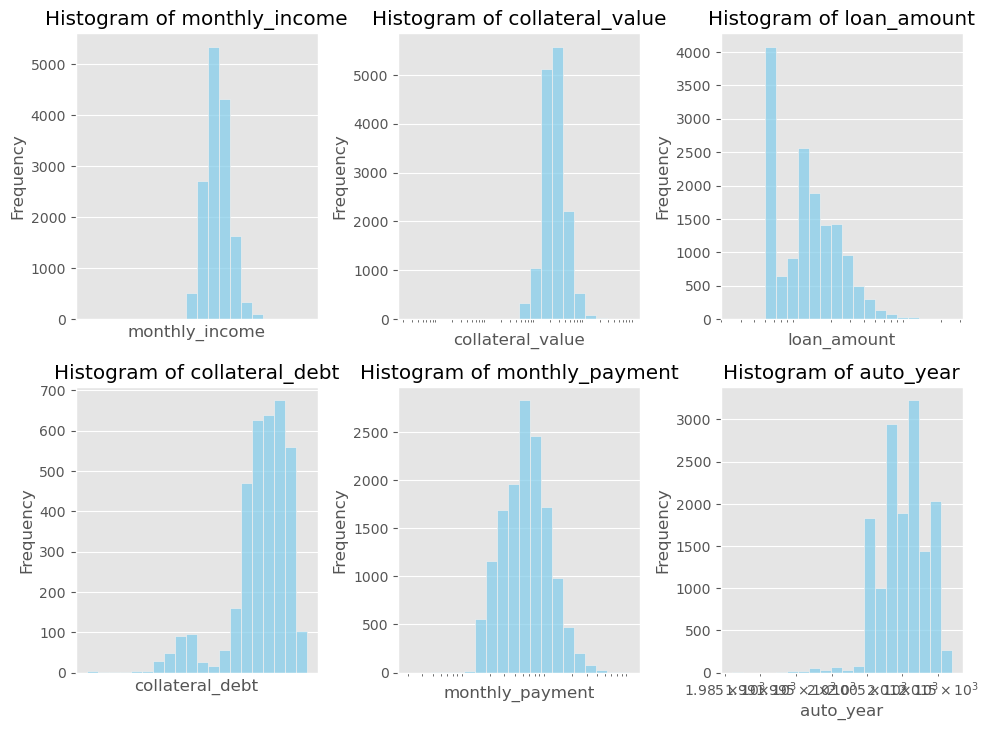

In [26]:
print('Numéricas')
plot_histograms(df, LOG_SCALE_COL, log_scale=True)

In [76]:
filtered_num_cols = [col for col in num_cols if col not in LOG_SCALE_COL]

Numéricas sem log scale


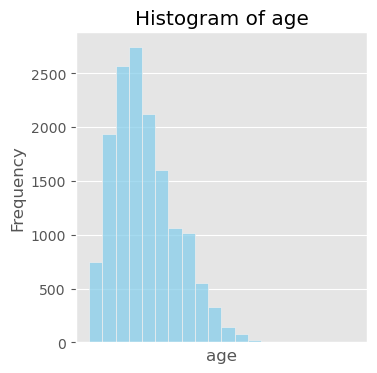

In [77]:
print('Numéricas sem log scale')
plot_histograms(df, ["age"])

In [78]:
filtered_num_cols.remove("age")
filtered_num_cols.remove("loan_term")

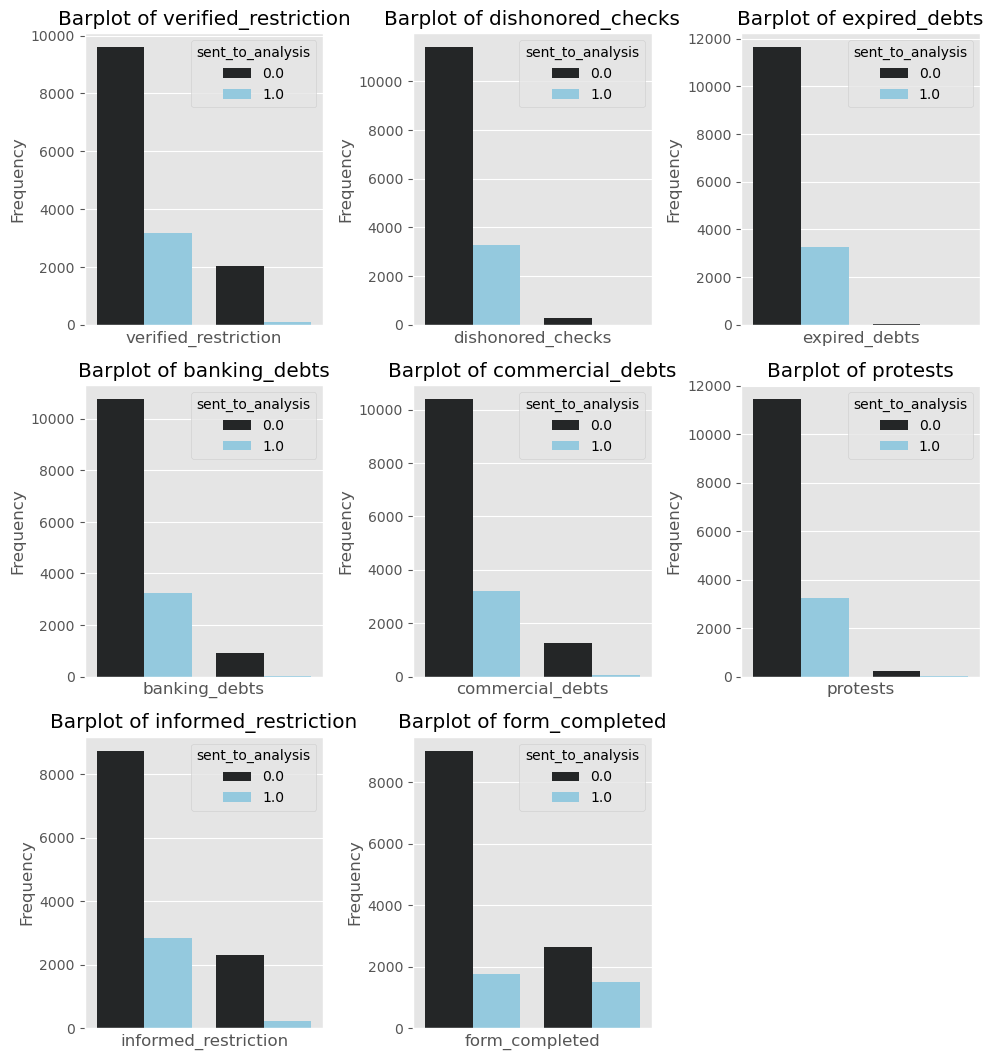

In [79]:
plot_boxplot(df, filtered_num_cols, hue="sent_to_analysis")

-------------------------------------------------------------------------------------------

# Análise Univariada

## Channel

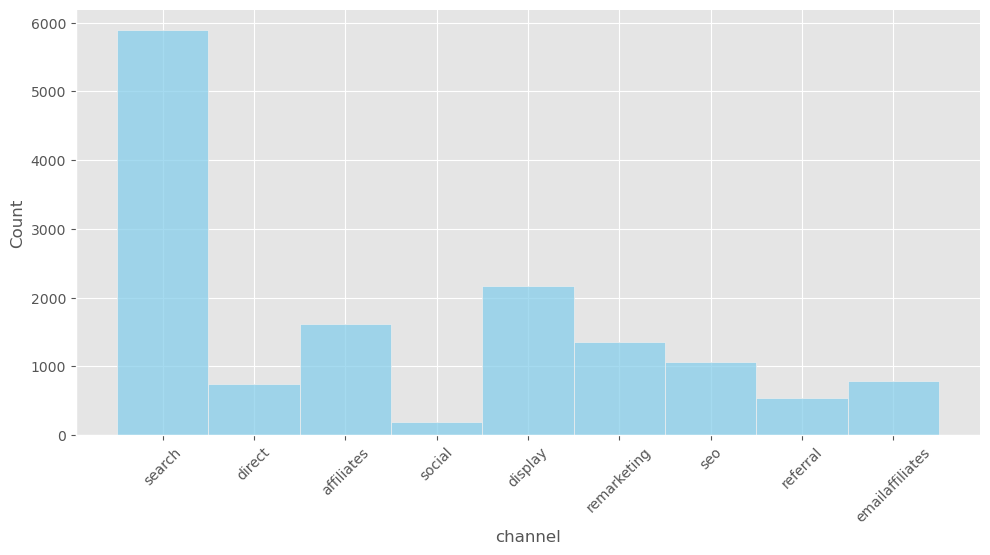

In [29]:
my_plot = sns.displot(data=df,x="channel",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45)

## Landing Page Product

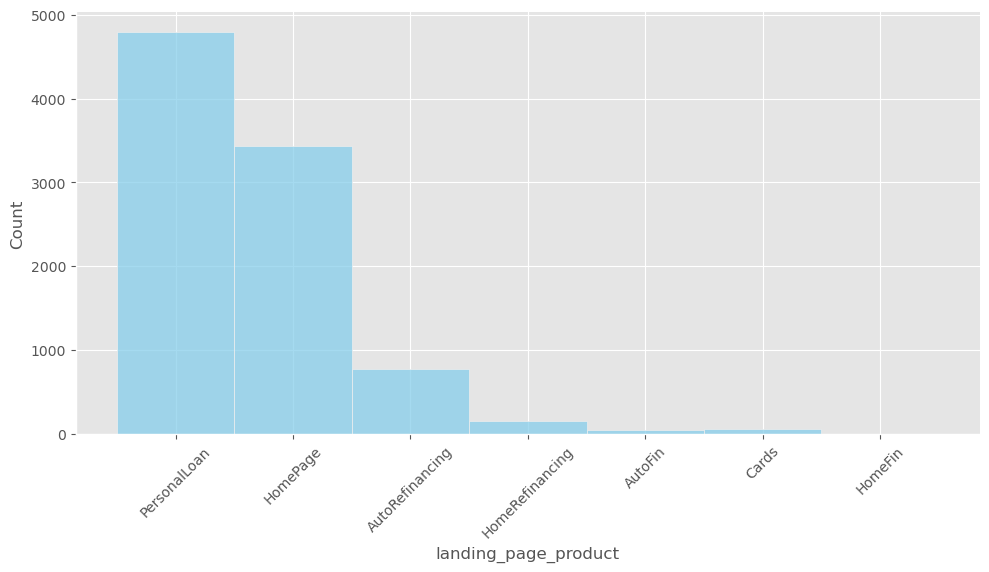

In [30]:
my_plot = sns.displot(data=df,x="landing_page_product",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45)

## UTM Term

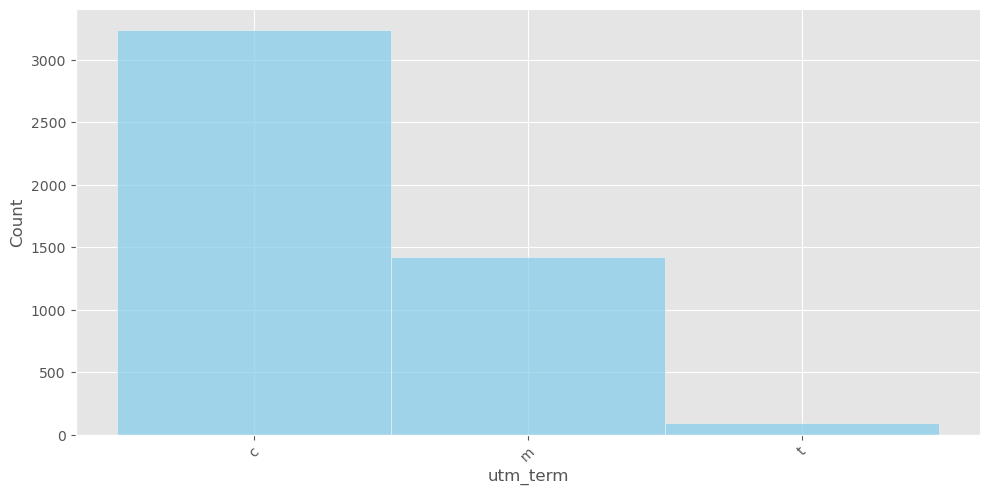

In [31]:
my_plot = sns.displot(data=df,x="utm_term",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45)

##  Auto Year

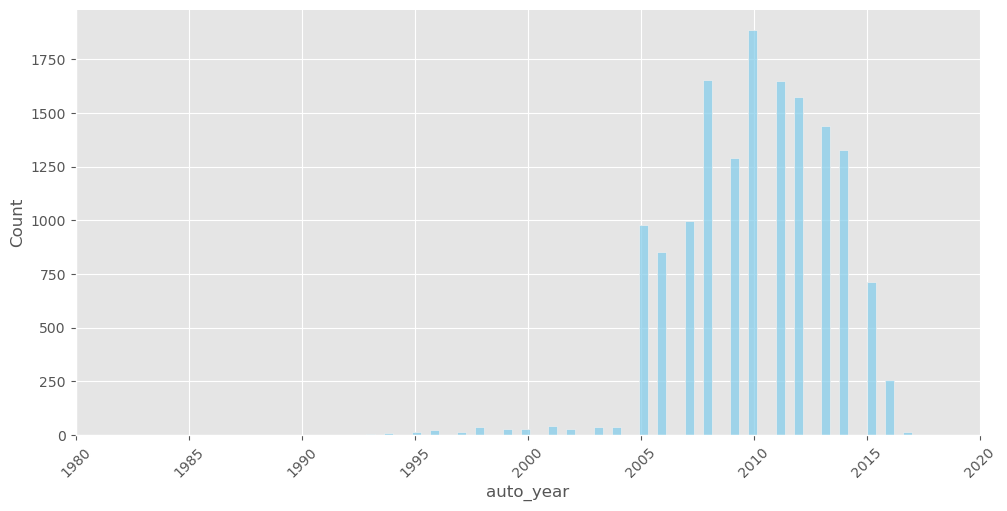

In [32]:
my_plot = sns.displot(data=df,x="auto_year",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45)

----------------------------------------------------------------------------

# Análise Bivariada

## Loan Amount 

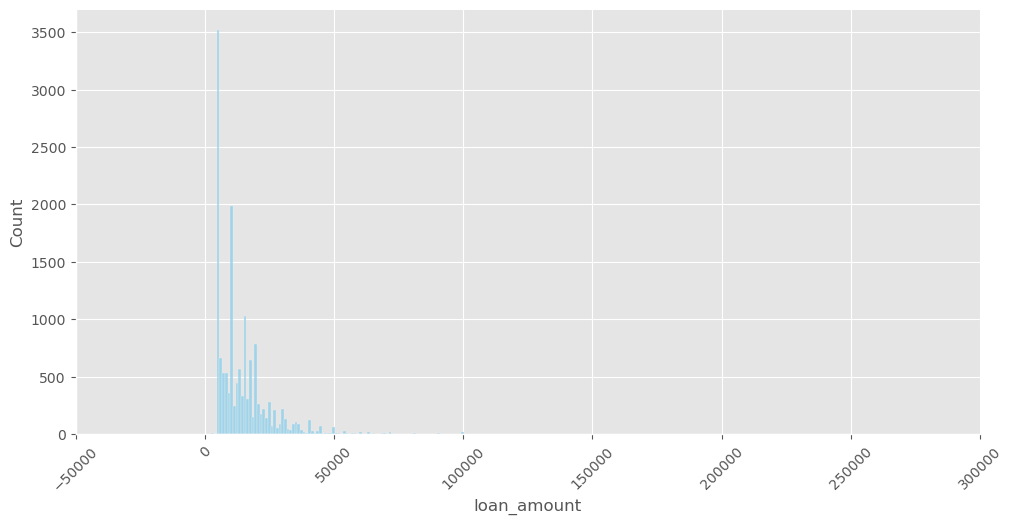

In [33]:
my_plot = sns.displot(data=df,x="loan_amount",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45) 

<Axes: xlabel='loan_amount'>

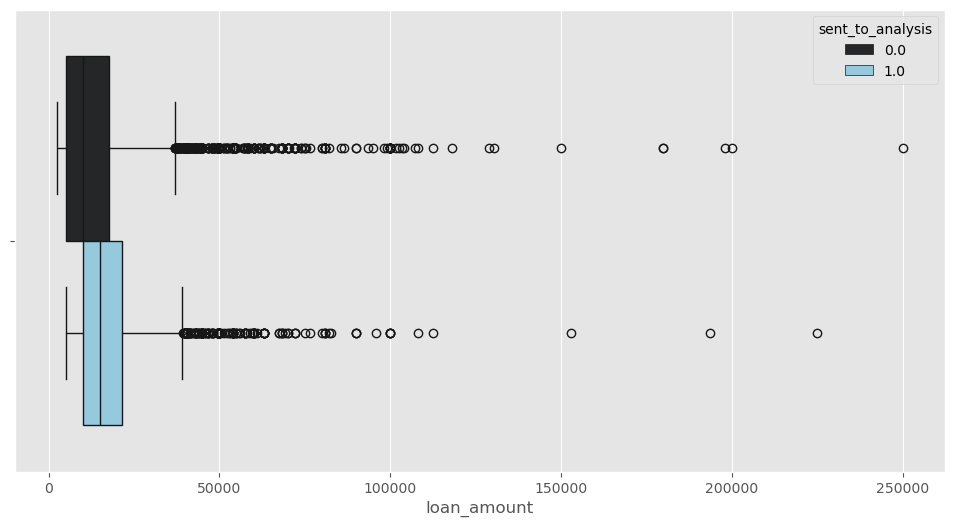

In [92]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,x="loan_amount", hue=TARGET_VARIABLE, color="skyblue")

## Collateral Debt

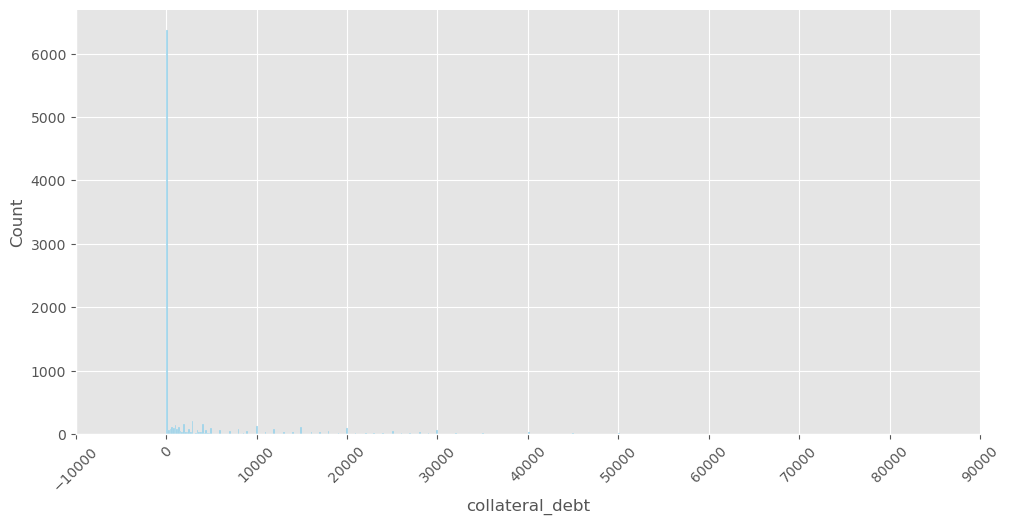

In [37]:
my_plot = sns.displot(data=df,x="collateral_debt",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45) 

<Axes: xlabel='collateral_debt'>

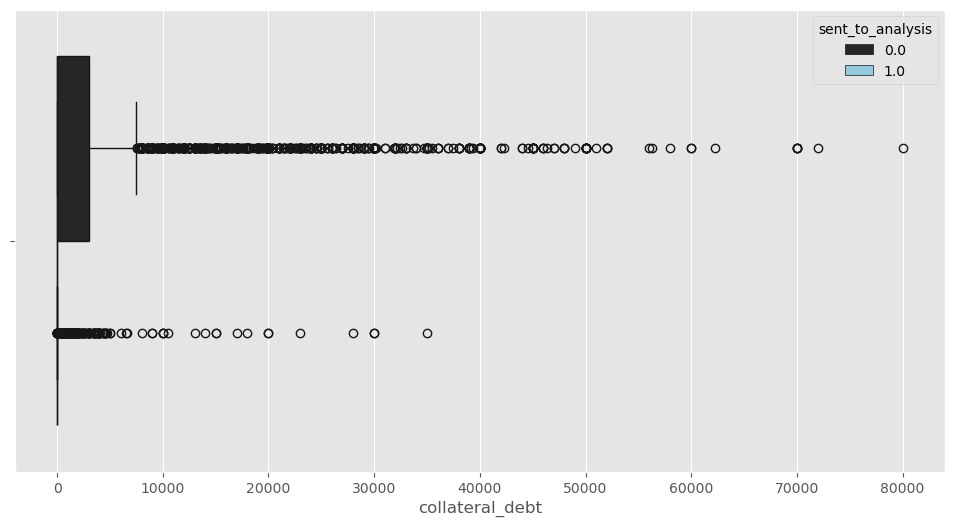

In [93]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,x="collateral_debt", hue=TARGET_VARIABLE, color="skyblue")

## Monthly Income

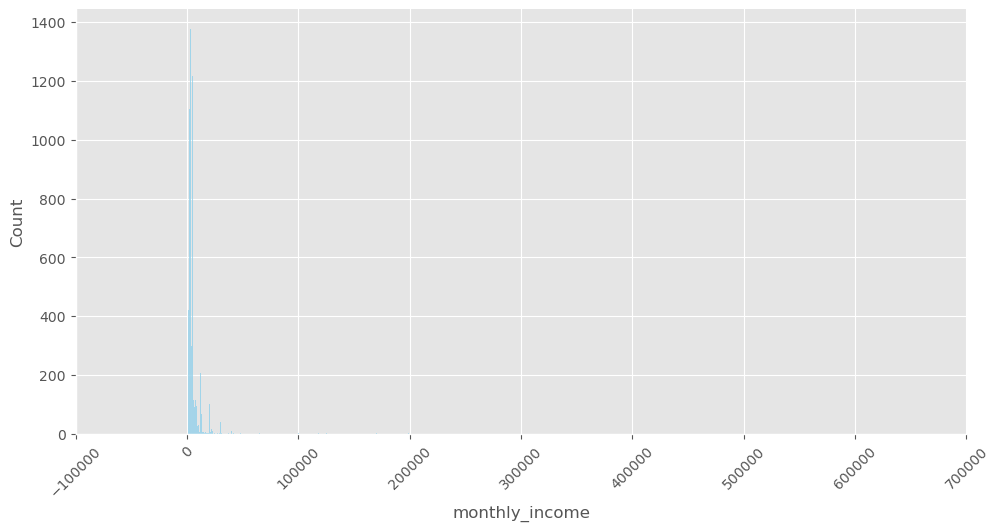

In [94]:
my_plot = sns.displot(data=df,x="monthly_income",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45) 

<Axes: xlabel='monthly_income'>

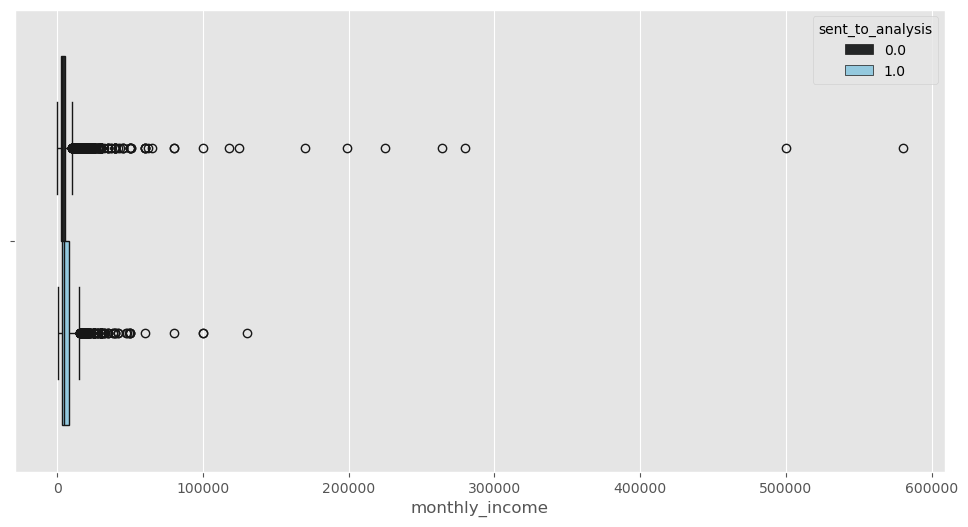

In [95]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,x="monthly_income", hue=TARGET_VARIABLE, color="skyblue")

## Monthly Payment

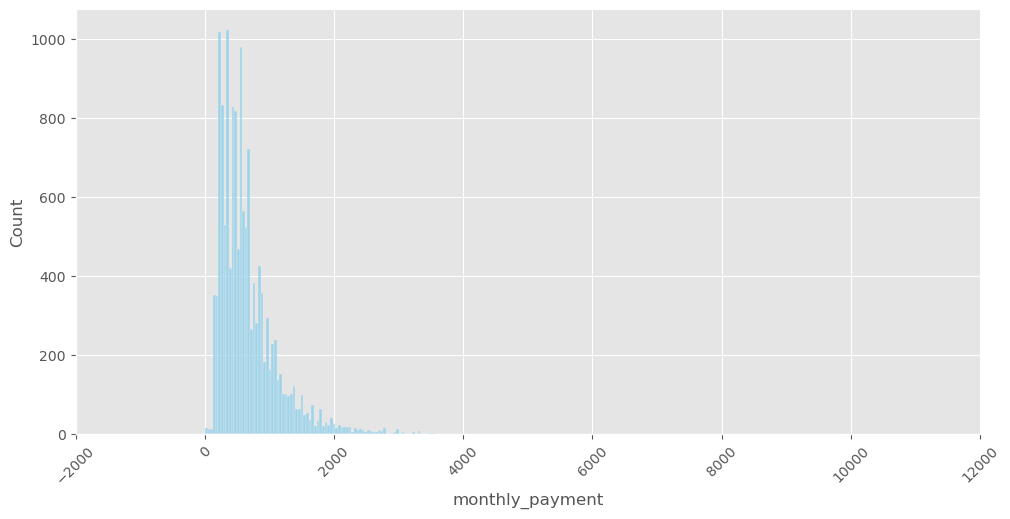

In [97]:
my_plot = sns.displot(data=df,x="monthly_payment",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45) 

<Axes: xlabel='monthly_payment'>

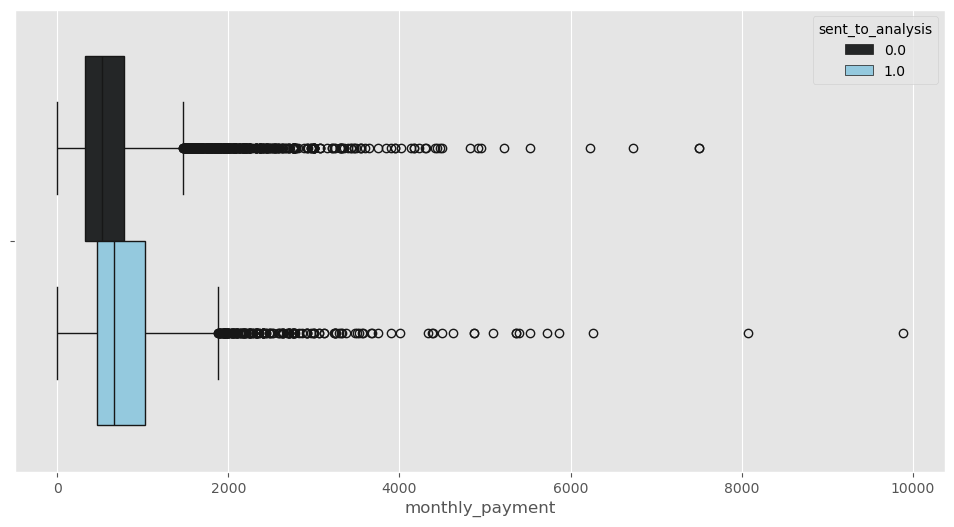

In [96]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,x="monthly_payment", hue=TARGET_VARIABLE, color="skyblue")

## Collateral Value

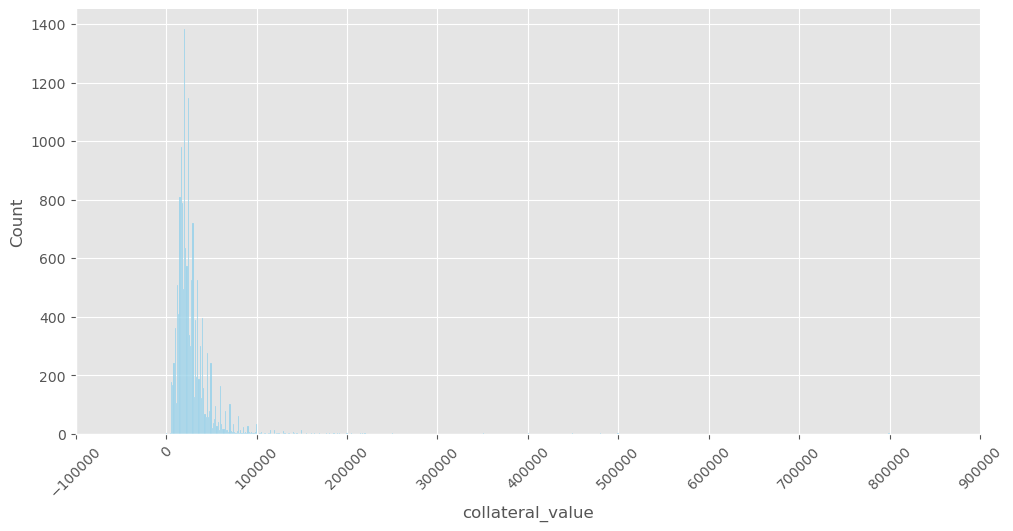

In [99]:
my_plot = sns.displot(data=df,x="collateral_value",color="skyblue",height=5,aspect=2)
my_plot.set_xticklabels(rotation=45) 

<Axes: xlabel='collateral_value'>

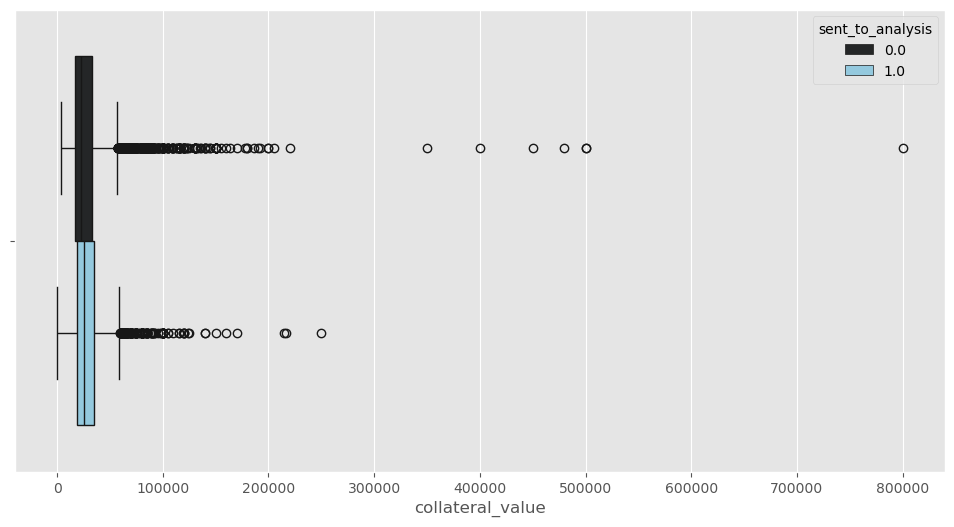

In [100]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df,x="collateral_value", hue=TARGET_VARIABLE, color="skyblue")

-----------------------------------------------------------------------------------------------------

# Análise Multivariada 

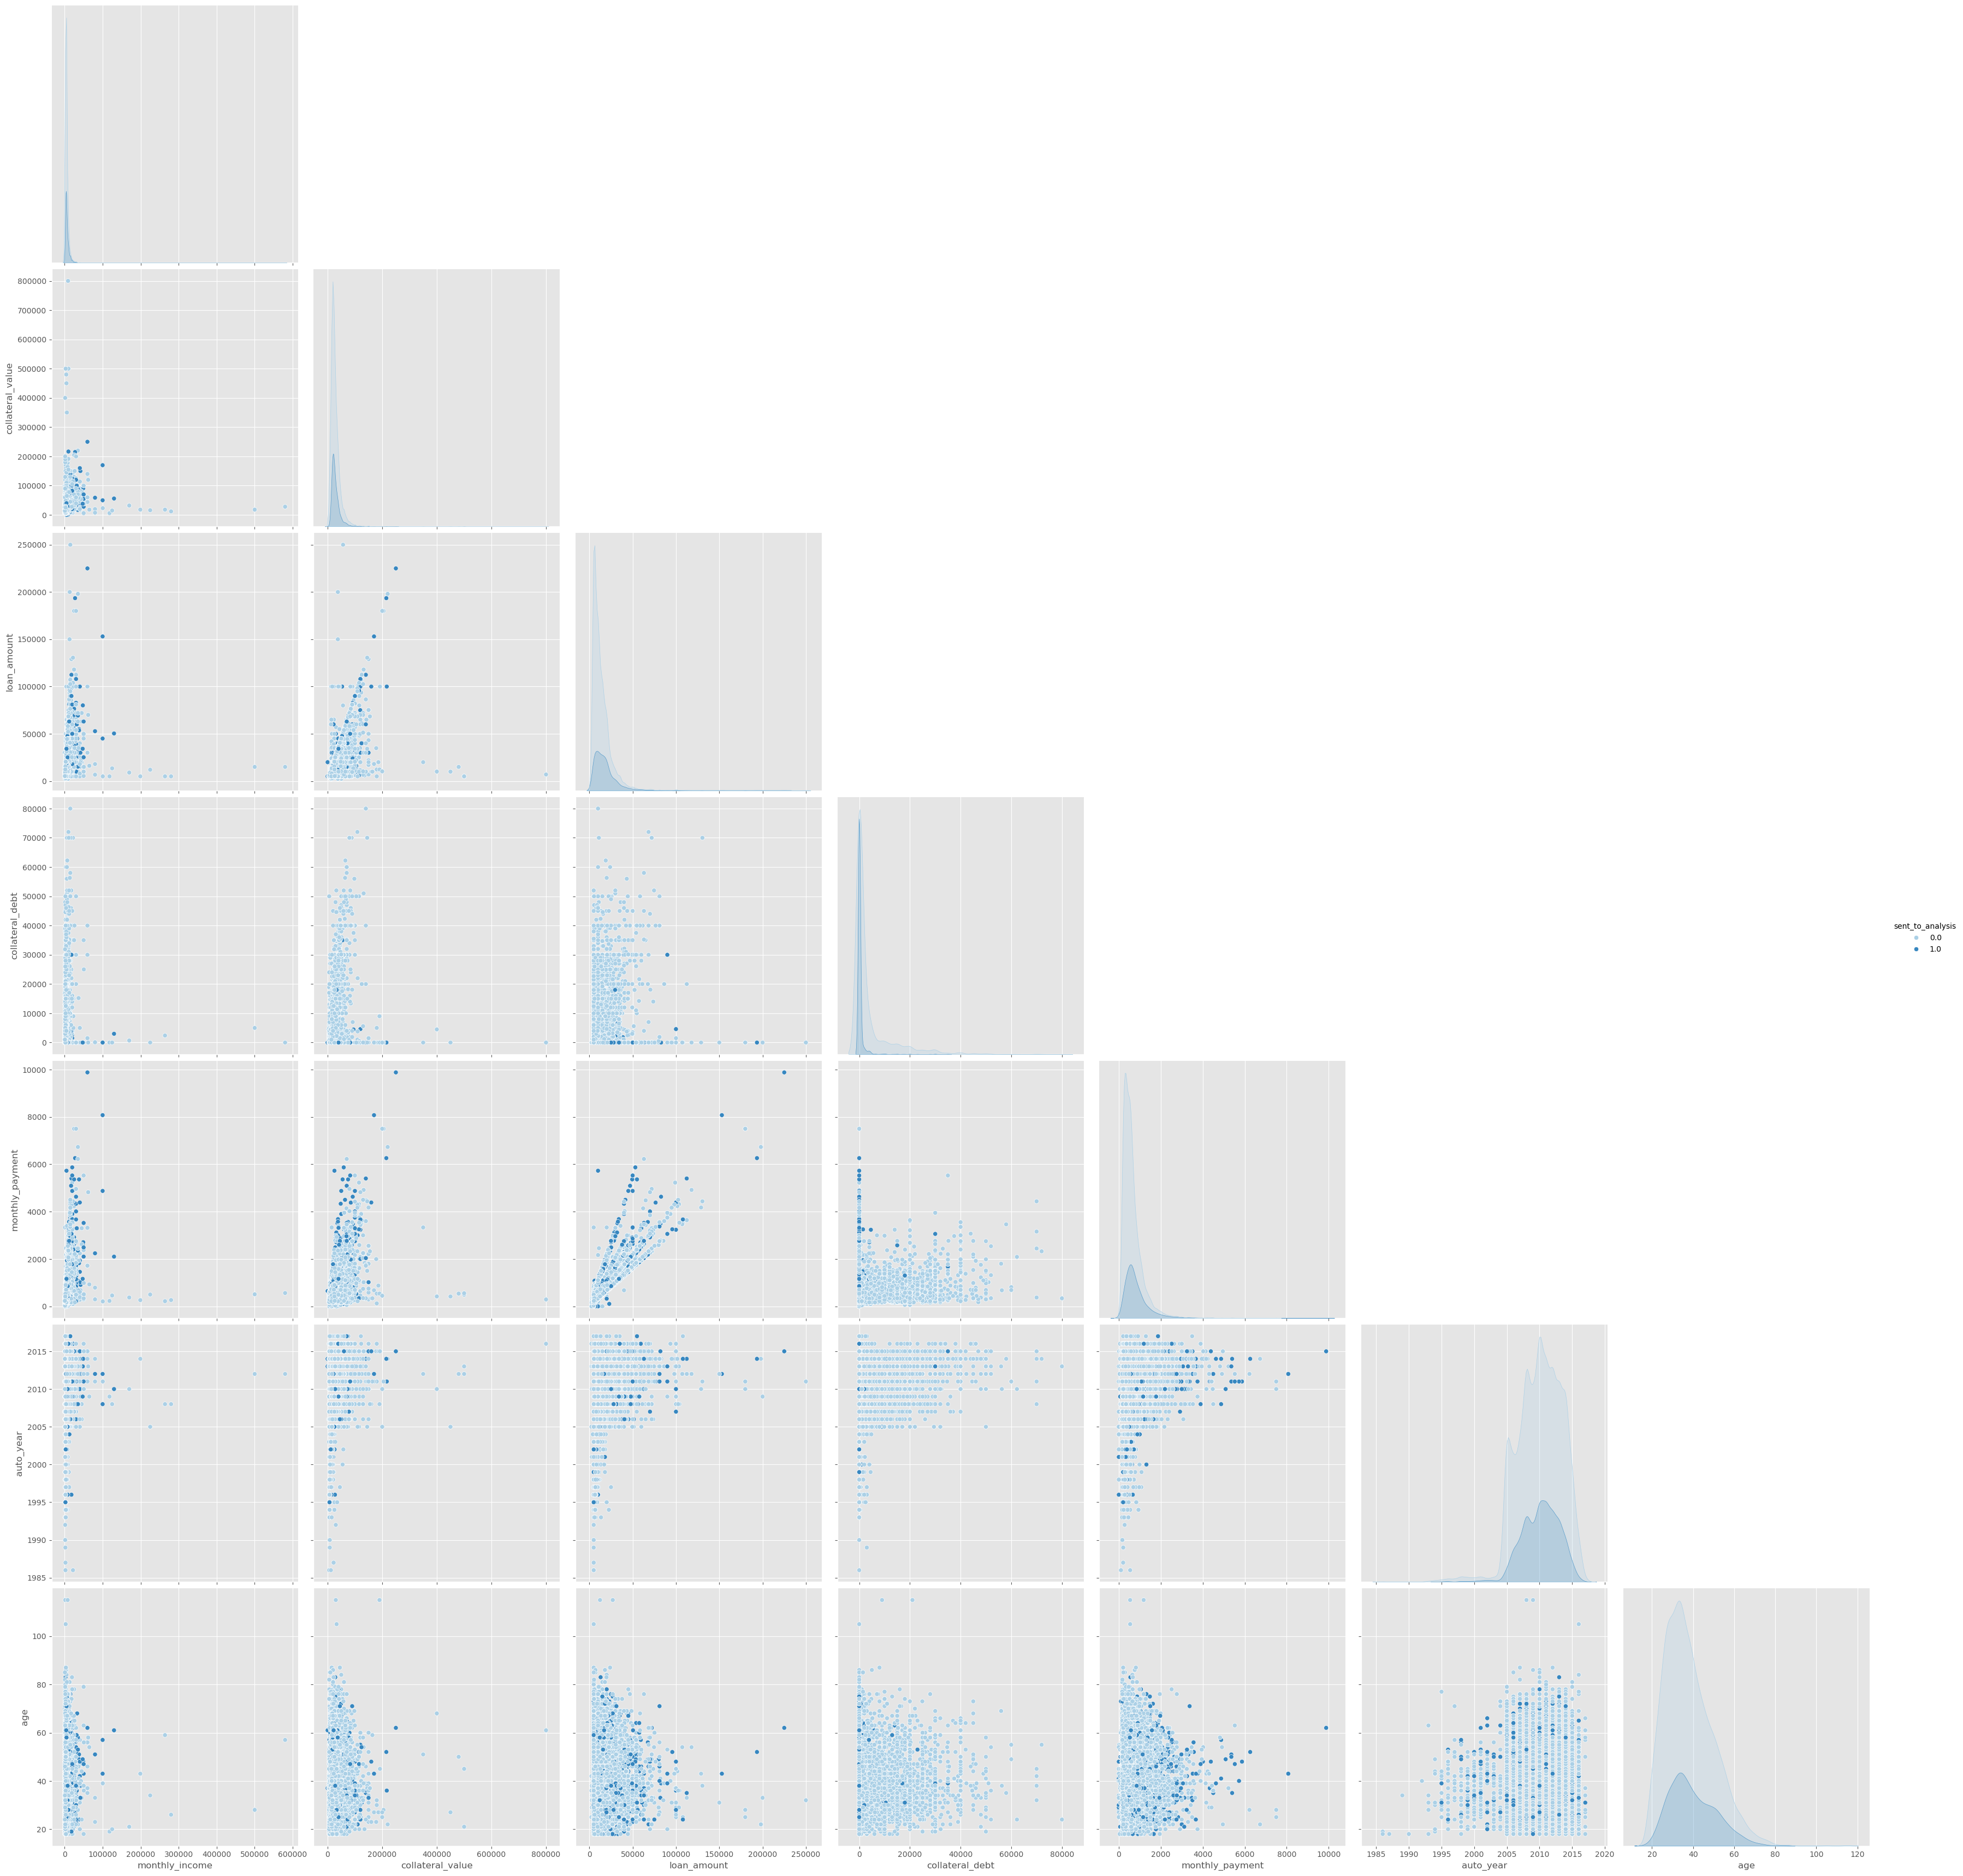

In [51]:
sns.pairplot(df[PAIR_PLOT], palette="Blues", hue="sent_to_analysis", height=5.0, corner=True)